In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
# plt.style.use("grayscale")

In [32]:
df = pd.read_csv("./space/pulsar_stars.csv")

In [33]:
df.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [34]:
df["target_class"].value_counts()

0    16259
1     1639
Name: target_class, dtype: int64

In [36]:
X = df.drop(["target_class"], axis=1).values
X.shape

(17898, 8)

In [37]:
y = df["target_class"]
y.shape

(17898,)

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

((13423, 8), (4475, 8))

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
X_train_std.shape, X_test_std.shape

((13423, 8), (4475, 8))

In [40]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression().fit(X_train_std, y_train)
score = {"LogisticRegression" : {"Train" : log_model.score(X_train_std, y_train),
                               "Test"  : log_model.score(X_test_std, y_test)}}
pd.DataFrame(score)

,LogisticRegression
Test,0.976536
Train,0.979364


In [84]:
from algorithms import SimpleESClassifier
from algorithms import GeneticESClassifier
from algorithms import NaturalESClassifier
from algorithms import DifferentialEvolutionClassifier

def score(objective, iterations=100):
    bounds = np.array([(-20, 20)] * (1 + X_train_std.shape[1]))

    ses = SimpleESClassifier(objective=objective, n_iter=iterations, random_state=0)
    ges = GeneticESClassifier(objective=objective, n_iter=iterations, random_state=0)
    nes = NaturalESClassifier(objective=objective, n_iter=iterations, random_state=0)
    dev = DifferentialEvolutionClassifier(objective=objective, n_iter=iterations * 10, random_state=0, bounds=bounds)

    ses.fit(X_train_std, y_train)
    ges.fit(X_train_std, y_train)
    nes.fit(X_train_std, y_train)
    dev.fit(X_train_std, y_train)

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), subplot_kw={"yticks": ()})
    axes[0][0].set_title("Simple ES")
    axes[0][0].plot(range(iterations), ses.history_)
    axes[0][1].set_title("Genetic ES")
    axes[0][1].plot(range(iterations), ges.history_)
    axes[1][0].set_title("Natural ES")
    axes[1][0].plot(range(iterations), nes.history_)
    axes[1][1].set_title("Differential Evolution")
    axes[1][1].plot(range(iterations * 10), dev.history_)

    score = {"SimpleES" : {"Train" : ses.score(X_train_std, y_train),
                           "Test"  : ses.score(X_test_std, y_test)},
             "GeneticES" : {"Train" : ges.score(X_train_std, y_train),
                            "Test"  : ges.score(X_test_std, y_test)},
             "NaturalES" : {"Train" : nes.score(X_train_std, y_train),
                            "Test"  : nes.score(X_test_std, y_test)},
             "DifferentialEvolution" : {"Train" : dev.score(X_train_std, y_train),
                                        "Test"  : dev.score(X_test_std, y_test)}}
    return pd.DataFrame(score)

100%|██████████| 1000/1000 [00:08<00:00, 112.31it/s]


,SimpleES,GeneticES,NaturalES,DifferentialEvolution
Train,0.557178,0.155479,0.609327,0.910005
Test,0.559106,0.167374,0.612737,0.903687


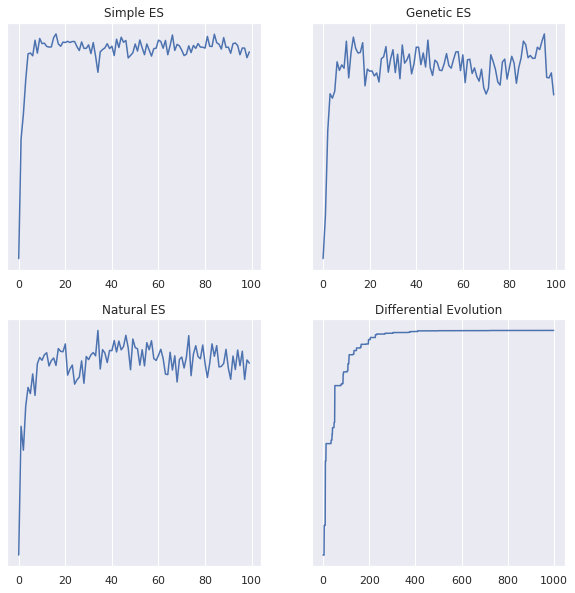

In [87]:
from objectives import MultiCrossEntropyObjective

score(MultiCrossEntropyObjective())

Not what I was expecting, but interesting. I might have implemented the objective function incorrectly, but then that brings into question how the DE performs *alright*. Maybe something else is going on. We could go on tweaking hyperparameters, or simply get around it by optimizing the model's `score` function directly! 

100%|██████████| 1000/1000 [00:22<00:00, 45.16it/s]


,SimpleES,GeneticES,NaturalES,DifferentialEvolution
Train,0.980928,0.980854,0.980183,0.981077
Test,0.978994,0.978547,0.977430,0.977877


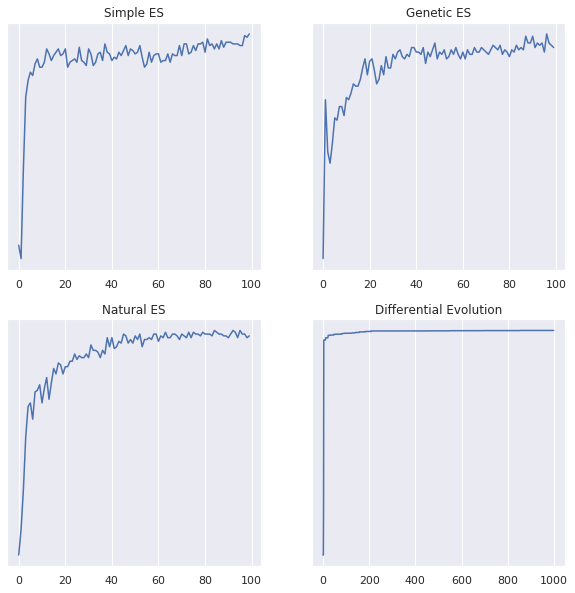

In [90]:
from objectives import ScoreObjective

score(ScoreObjective())